# Lab IV

## Exercise 1
### Part i

relative error at nodes: 0.008063%


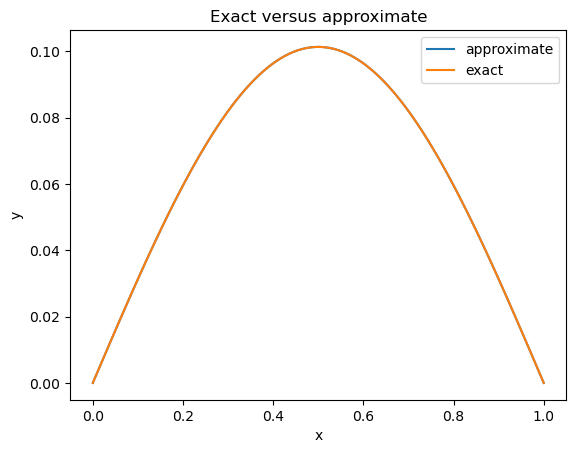

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def solve_centered_difference(a,b,N,p,f,ga,gb):
    # approximate the solution to 
    # 
    # -p * u'' = f(x) on (a,b)
    # u(a) = ga
    # u(b) = gb
    #
    # using a centered finite difference method
    #
    # input:
    #       a - left endpoint of domain
    #       b - right endpoint of domain
    #       N - divide the domain [a,b] into N+1 subintervals with points xi = a + i * (b-a)/(N+1)
    #       p - constant
    #       f - right hand side, function of x that returns a scalar
    #       ga - constant
    #       gb - constant
    #
    # output:
    #        xs - the nodes of the discretization, vector with xs[i] = a + i * (b-a)/(N+1)
    #        us - the approximate solution at the nodes, vector with us[i] = approximation to u at xs[i]
    
    # discretization
    h = (b-a)/(N+1)
    xs = [a + i * h for i in range(N+2)]
    
    # data structures
    A = np.zeros((N+2,N+2))
    B = np.zeros(N+2)
    
    # system assembly
    for i in range(1,N+1):
        # A is the matrix of coefficients
        A[i,i-1] = -p # done 
        A[i,i] = 2 * p # done
        A[i,i+1] = -p  # done
        B[i] = f(xs[i]) * (h ** 2) # We multiplied h ** 2 to both sides
    
    # boundary conditions
    A[0,0] = 1 # done 
    B[0] = ga # done
    A[-1,-1] = 1 # done
    B[-1] = gb # done
    
    # solve
    us = np.linalg.solve(A,B)
    
    return xs, us

def test_centered_difference():
    # test the approximation using the method of manufactured solutions
    # choose a suitable twice differentiable function u, and then insert u into the ODE
    #
    # -p * u'' = f on (a,b)
    # u(a) = ga
    # u(b) = gb
    #
    # to compute the corresponding f, ga, and gb
    # then use f, ga, and gb in the solver to compute the approximation uh to u
    
    # parameters
    a = 0
    b = 1
    p = 1
    
    u_exact = lambda x : np.sin(np.pi * x) / (p * np.pi**2)
    dxu_exact = lambda x : np.cos(np.pi*x) / (p * np.pi) # first derivative
    dx2u_exact = lambda x : -np.sin(np.pi*x) / p # second derivative
    
    N = 100
    
    
    # manufactured data
    f = lambda x : -p * dx2u_exact(x)
    ga = u_exact(a)
    gb = u_exact(b)
    
    # approximate solution
    xs, uhs = solve_centered_difference(a,b,N,p,f,ga,gb)
    
    # error at nodes
    us = np.array([u_exact(x) for x in xs])
    errors = uhs - us
    print('relative error at nodes: {:.6f}%'.format(np.linalg.norm(errors)/np.linalg.norm(us)*100))
    
    # plot
    plt.plot(xs,uhs,label='approximate')
    plt.plot(xs,us,label='exact')
    plt.title('Exact versus approximate')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
test_centered_difference()

### Part ii

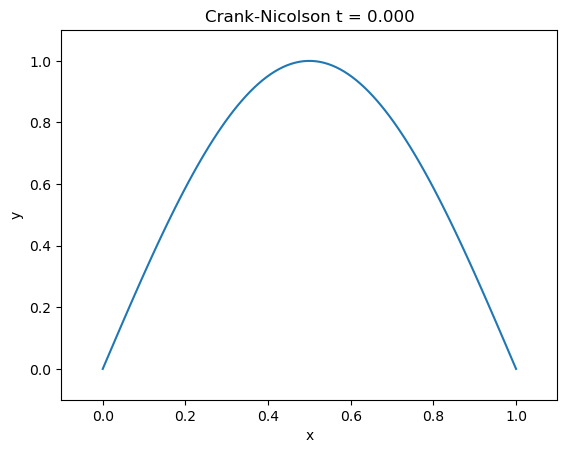

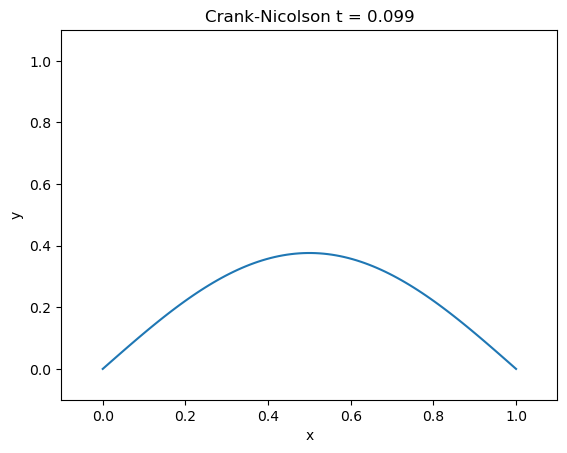

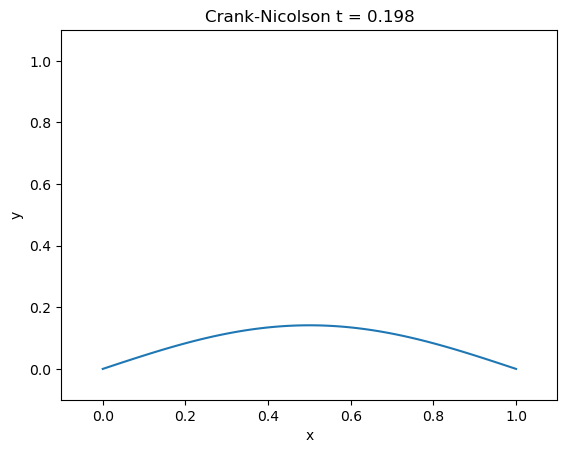

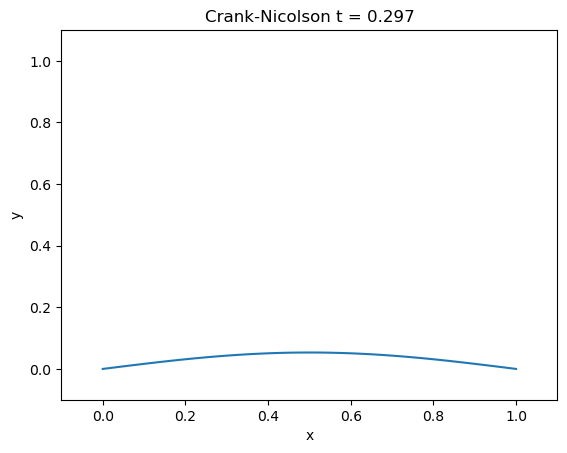

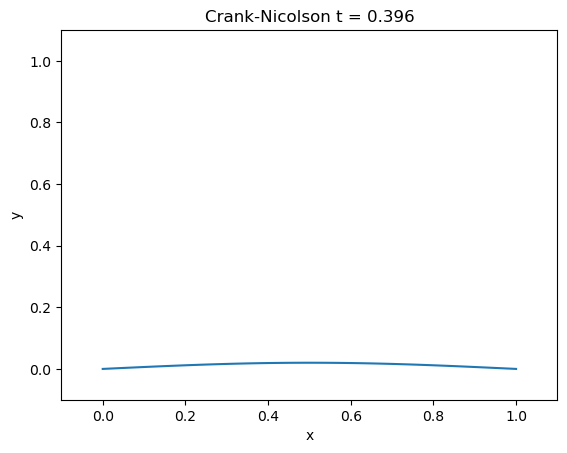

<Figure size 640x480 with 0 Axes>

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def solve_crank_nicolson(a,b,N,p,f,ga,gb,T,M,u0,n_snapshots):
    # approximate the solution to 
    # 
    # dt u -p * dx2 u = f(t,x) on (a,b) x (0,T)
    # u(x,0) = u0(x) for a < x < b
    # u(t,a) = ga(t) for 0 < t < T
    # u(t,b) = gb(t) for 0 < t < T
    #
    # using a centered finite difference method in space and the Crank-Nicolson scheme in time
    #
    # input:
    #       a - left endpoint of domain
    #       b - right endpoint of domain
    #       N - divide the domain [a,b] into N+1 subintervals with points xi = a + i * (b-a)/(N+1)
    #       p - constant
    #       f - right hand side, function of t,x that returns a scalar
    #       ga - left boundary data, function of t that returns a scalar
    #       gb - right boundary data, function of t that returns a scalar
    #       T - final time
    #       M - divide the time interval [0,T] into M+1 subintervals with points tn = n * T/(M+1)
    #       u0 - initial condition, function of x that returns a scalar
    #       n_snapshots - the number of snapshots to record the solution in time
    #                     for example, if the time points tn = [0.0, 0.1, 0.2, ..., 0.9, 1.0]
    #                     and we have n_snapshots = 4, then the approximate solution will be
    #                     recorded at 4 equally spaced time points [0.0, 0.3, 0.6, 0.9]
    #
    # output:
    #        xs - the nodes of the discretization, vector with xs[i] = a + i * (b-a)/(N+1)
    #        t_snapshots - the times tn at which a snapshot was taken, vector with t_snapshots[i] = ith snapshot time
    #        u_snapshots - the approximate solutions at the nodes for each snapshot time, 
    #                      list of vectors with u_snapshots[i][j] = approximate solution at the ith snapshot time and the jth node
    
    # discretization
    h = (b-a)/(N+1)
    xs = [a + i*h for i in range(N+2)]
    tau = T/(M+1)
    ts = [tau*n for n in range(M+2)]
    
    # time-independent data structures
    A = np.zeros((N+2,N+2)) # left hand side matrix
    
    # left hand side matrix assembly --- time independent
    for i in range(1,N+1):
        A[i,i-1] = -p * tau / (2 * (h ** 2)) # fixed
        A[i,i] = 1 + p * tau / (h ** 2) # fixed
        A[i,i+1] = -p * tau / (2 * (h ** 2)) # fixed
    # boundary conditions
    A[0,0] = 1 # fixed
    A[-1,-1] = 1 # fixed
    
    # initialize time-dependent data structures
    Bn = np.zeros(N+2) # right hand side vector at time n
    un = np.array([u0(x) for x in xs]) # approximation at time n
    un1 = np.zeros(N+2) # approximation at time n+1
    
    # snapshot data structures
    t_snapshots = []
    u_snapshots = []
    take_snapshots = range(0,M+2,int((M+2)/n_snapshots)) # take snapshots at these time steps
    i_snapshot = 0
    
    # time marching algorithm
    for n in range(M+1):
        # take a snapshot
        if n in take_snapshots:
            t_snapshots.append(ts[n])
            u_snapshot = np.zeros(N+2)
            for i in range(len(u_snapshot)):
                u_snapshot[i] = un[i]
            u_snapshots.append(u_snapshot)
            i_snapshot += 1
        
        # assemble time-dependent data structures
        for i in range(1,N+1):
            Bn[i] = un[i] + (p * tau / (2 * (h ** 2))) * (un[i+1] - 2 * un[i] + un[i-1]) 
            + (tau / 2) * (f(ts[n] , xs[i]) + f(ts[n+1], xs[i])) # fixed

        # boundary conditions
        Bn[0] = ga(ts[n]) # fixed
        Bn[-1] = gb(ts[n]) # fixed
        
        # solve
        un1 = np.linalg.solve(A,Bn)
        
        # update for next time step
        for i in range(N+2):
            un[i] = un1[i]
        
    return xs, t_snapshots, u_snapshots

def test_crank_nicolson():
    # test the approximation by varying the parameters
    a = 0
    b = 1
    f = lambda t,x : np.sin(np.pi*x)*np.sin(np.pi*t)
    ga = lambda t : 0
    gb = lambda t : 0
    u0 = lambda x : np.sin(np.pi * x)
    p = 1
    N = 100
    M = 100
    n_snapshots = 5
    T = 0.5
    
    
    xs, t_snapshots, u_snapshots = solve_crank_nicolson(a,b,N,p,f,ga,gb,T,M,u0,n_snapshots)
    
    for i in range(n_snapshots):
        plt.plot(xs,u_snapshots[i])
        plt.title('Crank-Nicolson t = {:.3f}'.format(t_snapshots[i]))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim(a-0.1,b+0.1)
        plt.ylim(min(u_snapshots[0])-0.1,max(u_snapshots[0]) + 0.1)
        plt.figure()

test_crank_nicolson()
# Observe that the solution is shrinking down to 0 over time
# The graphs are the snapshots of the solution over time
# It doesn't necessaily approach 0. It depends on the specific equation

## Exercise II
If you notice that your solution blows up before very quickly before it hits the boundary, try lowering the CFL constant.

cfl condition: c * tau / h = 1.00e-01 <= cfl = 1.00e-01 is violated


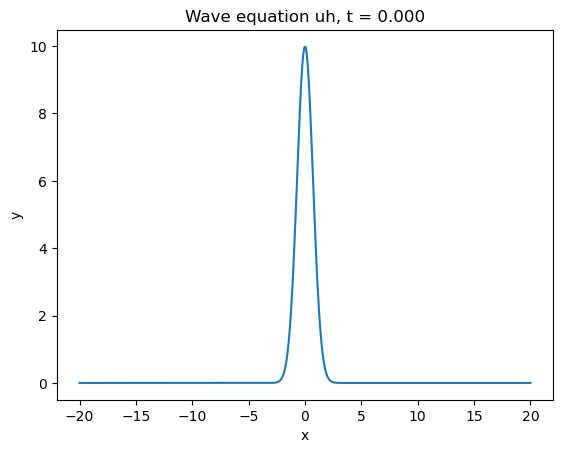

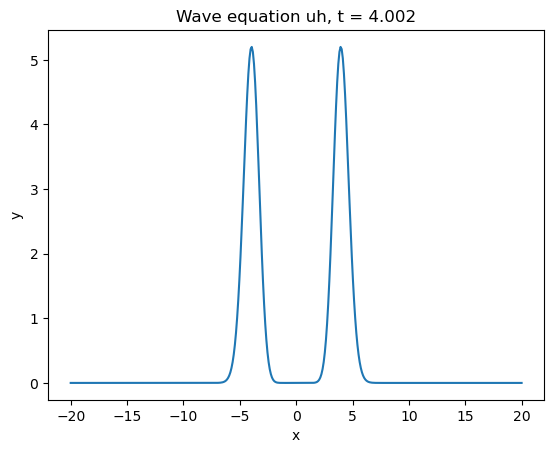

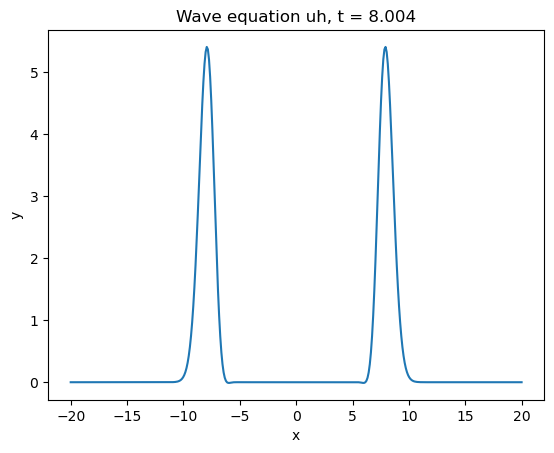

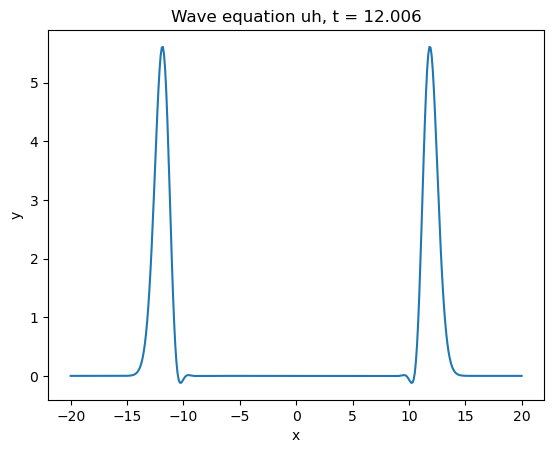

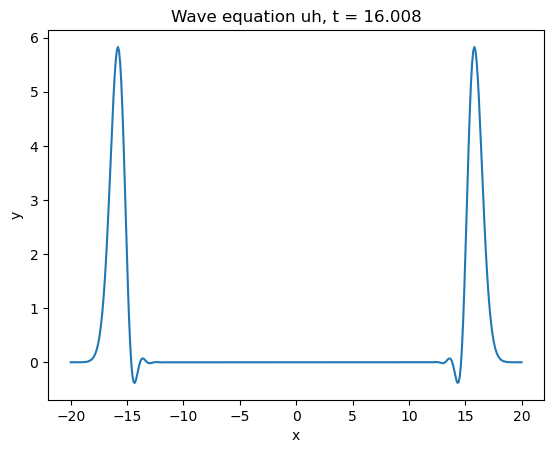

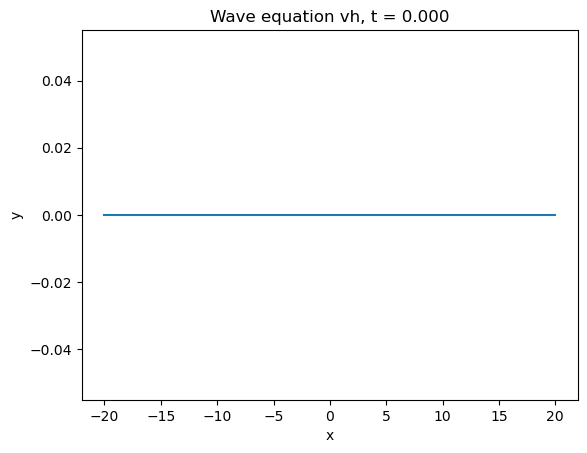

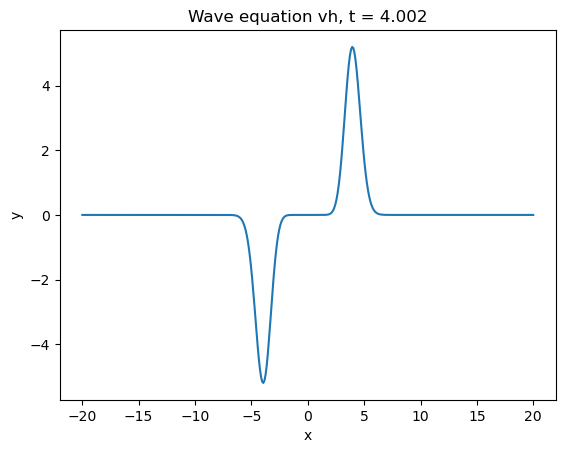

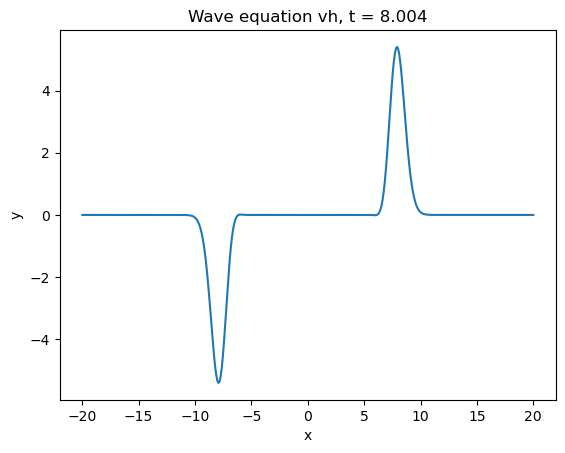

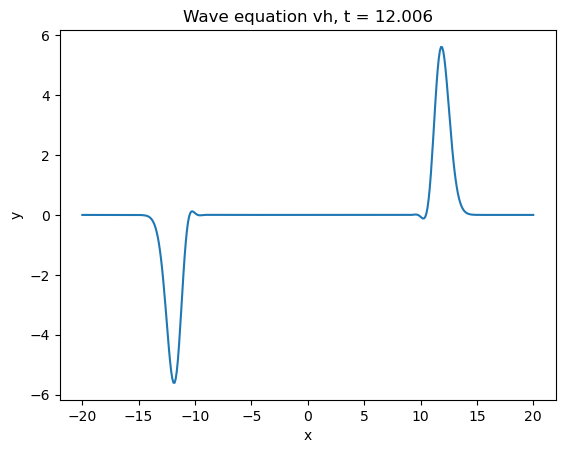

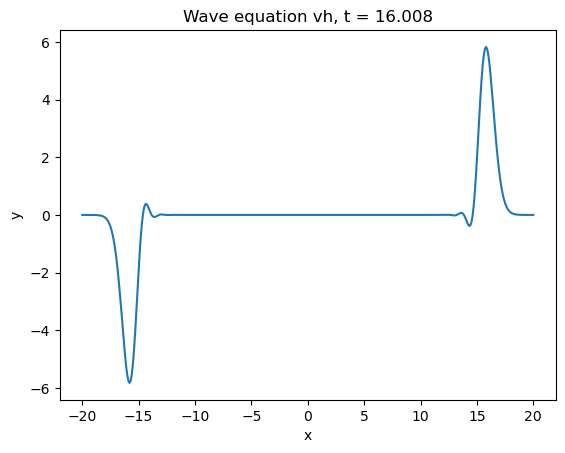

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def solve_wave(a,b,N,T,M,u0,v0,c,n_snapshots):
    # approximate the solution to 
    # 
    # dt u + dx v = 0 on (a,b) x (0,T)
    # dt v + c**2 * dx u = 0 on (a,b) x (0,T)
    # u(t,a) = v(t,a) = 0 for 0 < t < T
    # u(t,b) v(t,b) = 0 for 0 < t < T
    # u(x,0) = u0(x) for a < x < b
    # v(x,0) = v0(x) for a < x < b
    #
    # using forward Euler in time and a centered approximation in space
    #
    # input:
    #       a - left endpoint of domain
    #       b - right endpoint of domain
    #       N - divide the domain [a,b] into N+1 subintervals with points xi = a + i * (b-a)/(N+1)
    #       T - final time
    #       M - divide the time interval [0,T] into M+1 subintervals with points tn = n * T/(M+1)
    #       u0 - initial condition for u, function of x that returns a scalar
    #       v0 - initial condition for v, function of x that returns a scalar
    #       c - wavespeed
    #       n_snapshots - the number of snapshots to record the solution in time
    #                     for example, if the time points tn = [0.0, 0.1, 0.2, ..., 0.9, 1.0]
    #                     and we have n_snapshots = 4, then the approximate solution will be
    #                     recorded at 4 equally spaced time points [0.0, 0.3, 0.6, 0.9]
    #
    # output:
    #        xs - the nodes of the discretization, vector with xs[i] = a + i * (b-a)/(N+1)
    #        t_snapshots - the times tn at which a snapshot was taken, vector with t_snapshots[i] = ith snapshot time
    #        u_snapshots - the approximate solutions for u at the nodes for each snapshot time, 
    #                      list of vectors with u_snapshots[i][j] = approximate solution at the ith snapshot time and the jth node
    #        v_snapshots - the approximate solutions for v at the nodes for each snapshot time, 
    #                      list of vectors with v_snapshots[i][j] = approximate solution at the ith snapshot time and the jth node
    
    # discretization
    h = (b-a)/(N+1)
    xs = [a + i*h for i in range(N+2)]
    tau = T/(M+1)
    ts = [n*tau for n in range(M+2)]
    
    # initialize time-dependent data structures
    uns = [u0(x) for x in xs] # approximation to u at time n
    un1s = np.zeros(N+2) # approximation to u at time n+1
    
    vns = [v0(x) for x in xs] # approximation to v at time n
    vn1s = np.zeros(N+2) # approximatoin to v at time n+1
    
    # snapshot data structures
    t_snapshots = []
    u_snapshots = []
    v_snapshots = []
    take_snapshots = range(0,M+2,int((M+2)/n_snapshots))
    i_snapshot = 0
    
    # time marching algorithm
    for n in range(M+1):
        # take a snapshot
        if n in take_snapshots:
            t_snapshots.append(ts[n])
            u_snapshot = np.zeros(N+2)
            v_snapshot = np.zeros(N+2)
            for i in range(len(u_snapshot)):
                u_snapshot[i] = uns[i]
                v_snapshot[i] = vns[i]
            u_snapshots.append(u_snapshot)
            v_snapshots.append(v_snapshot)
            i_snapshot += 1
        
        # advance in time
        for i in range(1,N+1):
            un1s[i] = uns[i] - tau / (2 * h) * (vns[i+1] - vns[i-1]) # done
            vn1s[i] = vns[i] - tau / (2 * h) * (uns[i+1] - uns[i-1]) # done
        
        # boundary conditions
        un1s[0] = 0
        un1s[-1] = 0
        vn1s[0] = 0
        vn1s[-1] = 0
        
        # update for next time step
        for i in range(N+2):
            uns[i] = un1s[i]
            vns[i] = vn1s[i]
    
    return xs, t_snapshots, u_snapshots, v_snapshots

def test_wave():
    # test the approximation by varying the parameters
    # if you notice that your solution blows up very quickly, try lowering the cfl constant
    
    cfl = 0.1
    a = -20
    b = 20
    c = 1
    T = 20
    n_snapshots = 5
    N = 10*(b-a)
    h = (b-a)/(N+1)
    xs = [a + i*h for i in range(N+2)]
    u0 = lambda x : (x-a)*(b-x)*np.exp(-x**2)/(b-a)
    v0 = lambda x : 0 
    
    # choose the number of time steps M so that when
    # h = (b-a)/(N+1)
    # tau = T/(M+1)
    # we have that c * tau <= cfl * h
    M = int(T / (cfl * h / c)) - 1 # fixed
    tau = T/(M+1)
    print('cfl condition: c * tau / h = {:.2e} <= cfl = {:.2e} '.format(c*tau / h,cfl) + ('is satisfied' if c*tau/h  <= cfl else 'is violated'))
    xs, t_snapshots, u_snapshots, v_snapshots = solve_wave(a,b,N,T,M,u0,v0,c,n_snapshots)
    
    for i in range(n_snapshots):
        plt.figure()
        plt.plot(xs,u_snapshots[i])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Wave equation uh, t = {:.3f}'.format(t_snapshots[i]))
        
    for i in range(n_snapshots):
        plt.figure()
        plt.plot(xs,v_snapshots[i])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Wave equation vh, t = {:.3f}'.format(t_snapshots[i]))
        
        
test_wave()